Get the Twitter API keys

In [140]:
# load keys for Twitter API
key_path = '/content/drive/My Drive/Colab Notebooks/Keys.txt'
f = open(key_path, "r")
API_keys = {i.split('\'')[0].replace(':',''):i.split('\'')[1] for i in f.readlines()}
API_keys.keys()

dict_keys(['Access_token', 'Access_token_secret', 'consumer_key', 'consumer_secret'])

Get the latest Tweets

In [248]:
import tweepy
import csv

def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(API_keys['consumer_key'], API_keys['consumer_secret'])
    auth.set_access_token(API_keys['Access_token'], API_keys['Access_token_secret'])
    api = tweepy.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (900 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,
                                   count=900, 
                                   include_rts = False,
                                   tweet_mode="extended")
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print(f"getting tweets before {oldest}")
        
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,
                                       count=900,
                                       max_id=oldest,
                                       include_rts = False,
                                       tweet_mode="extended")
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"...{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [[tweet.id_str, tweet.created_at, tweet.full_text] for tweet in alltweets]
    
    #write the csv  
    with open(f'new_{screen_name}_tweets.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)
    
    return outtweets

In [249]:
tweets = get_all_tweets('realDonaldTrump')

getting tweets before 1301246706525241345
...173 tweets downloaded so far
getting tweets before 1300007786101772287
...323 tweets downloaded so far
getting tweets before 1298117373464137727
...446 tweets downloaded so far
getting tweets before 1295775212408131584
...516 tweets downloaded so far
getting tweets before 1294264832200515583
...615 tweets downloaded so far
getting tweets before 1291435765575176191
...702 tweets downloaded so far
getting tweets before 1289283091635122175
...768 tweets downloaded so far
getting tweets before 1287490820669616127
...825 tweets downloaded so far
getting tweets before 1284352067096772608
...886 tweets downloaded so far
getting tweets before 1281919692123316223
...988 tweets downloaded so far
getting tweets before 1278892544894668800
...1081 tweets downloaded so far
getting tweets before 1276995624588709887
...1216 tweets downloaded so far
getting tweets before 1273740314788990976
...1325 tweets downloaded so far
getting tweets before 1271145584791

In [1]:
import re

def remove_pattern(input_txt, old_pattern, new_pattern):
    r = re.findall(old_pattern, input_txt)
    for i in r:
        input_txt = input_txt.replace(i,new_pattern)
    return input_txt

In [16]:
import pandas as pd

df = pd.read_csv('new_realDonaldTrump_tweets.csv')

df.head()

,id,created_at,text
0,1302985926809923589,2020-09-07 15:03:47,Biggest and Fastest Financial Recovery In Hist...
1,1302972258034614273,2020-09-07 14:09:29,"Rochester N.Y., Brooklyn N.Y., Portland - All ..."
2,1302970414394740736,2020-09-07 14:02:09,"10.6 Million Jobs Created In Just 4 Months, A ..."
3,1302969740374298624,2020-09-07 13:59:28,"Biden Underperforming! @OANN What else is new,..."
4,1302968271306711046,2020-09-07 13:53:38,Gordon Chang: China Seems ‘to Be Favoring Joe ...


Cleaning tweet text

In [17]:
import numpy as np

# Remove twitter handles (@user)
df['clean_text'] = np.vectorize(remove_pattern)(df['text'], '@\S*', '')

# Other rules to remove
to_remove = ['\\n', 'http\S*', ' via '] 
for rem in to_remove:
  df['clean_text'] = np.vectorize(remove_pattern)(df['clean_text'], rem, '')

# Change &amps to and
df['clean_text'] = np.vectorize(remove_pattern)(df['clean_text'], '&amp;', 'and')

# Remove extrawhitespaces
def rmv_ws(s):
  return ' '.join(s.split())

df['clean_text'] = np.vectorize(rmv_ws)(df['clean_text'])

# results
df.head()

,id,created_at,text,clean_text
0,1302985926809923589,2020-09-07 15:03:47,Biggest and Fastest Financial Recovery In Hist...,Biggest and Fastest Financial Recovery In Hist...
1,1302972258034614273,2020-09-07 14:09:29,"Rochester N.Y., Brooklyn N.Y., Portland - All ...","Rochester N.Y., Brooklyn N.Y., Portland - All ..."
2,1302970414394740736,2020-09-07 14:02:09,"10.6 Million Jobs Created In Just 4 Months, A ...","10.6 Million Jobs Created In Just 4 Months, A ..."
3,1302969740374298624,2020-09-07 13:59:28,"Biden Underperforming! @OANN What else is new,...","Biden Underperforming! What else is new, the s..."
4,1302968271306711046,2020-09-07 13:53:38,Gordon Chang: China Seems ‘to Be Favoring Joe ...,Gordon Chang: China Seems ‘to Be Favoring Joe ...


In [18]:
# drop rows with empty clean_text

print(df['clean_text'].str.len().min())
df['clean_text'][df['clean_text'] == ''] = np.nan
df = df.dropna()
print(df['clean_text'].str.len().min())

# Reset index
df = df.reset_index()

0
4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Loading Model

In [5]:
import tensorflow as tf
from tensorflow import keras

model_RNN = tf.keras.models.load_model('my_model_RNN.h5')
model_LSTM = tf.keras.models.load_model('my_model_LSTM.h5')

In [6]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(model, sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [7]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)

encoder = info.features['text'].encoder

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKB2R2F/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKB2R2F/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKB2R2F/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [19]:
sample_pred_text = df['clean_text'][0]

sample_pred_text

'Biggest and Fastest Financial Recovery In History. Next year will be the best ever, unless a Sleepy person, who wants to massively raise your taxes, gets in. I’m which case, CRASH!!!'

In [20]:
predictions = sample_predict(model_LSTM, sample_pred_text, pad=True)
print(predictions)

[[1.0774969]]


In [10]:
predictions_RNN = []
predictions_LSTM = []
for i in range(len(df)):
  pred_text = df['clean_text'][i]
  predictions_RNN.append(sample_predict(model_LSTM, pred_text, pad=True))
  predictions_LSTM.append(sample_predict(model_LSTM, pred_text, pad=True))

In [21]:
df['Predictions_RNN'] = predictions_RNN
df['Predictions_LSTM'] = predictions_LSTM

df.head()

,index,id,created_at,text,clean_text,Predictions_RNN,Predictions_LSTM
0,0,1302985926809923589,2020-09-07 15:03:47,Biggest and Fastest Financial Recovery In Hist...,Biggest and Fastest Financial Recovery In Hist...,[[1.0774969]],[[1.0774969]]
1,1,1302972258034614273,2020-09-07 14:09:29,"Rochester N.Y., Brooklyn N.Y., Portland - All ...","Rochester N.Y., Brooklyn N.Y., Portland - All ...",[[1.7239271]],[[1.7239271]]
2,2,1302970414394740736,2020-09-07 14:02:09,"10.6 Million Jobs Created In Just 4 Months, A ...","10.6 Million Jobs Created In Just 4 Months, A ...",[[4.816497]],[[4.816497]]
3,3,1302969740374298624,2020-09-07 13:59:28,"Biden Underperforming! @OANN What else is new,...","Biden Underperforming! What else is new, the s...",[[-1.6248175]],[[-1.6248175]]
4,4,1302968271306711046,2020-09-07 13:53:38,Gordon Chang: China Seems ‘to Be Favoring Joe ...,Gordon Chang: China Seems ‘to Be Favoring Joe ...,[[-0.8527375]],[[-0.8527375]]


In [22]:
df['Predictions_RNN'][0]

array([[1.0774969]], dtype=float32)

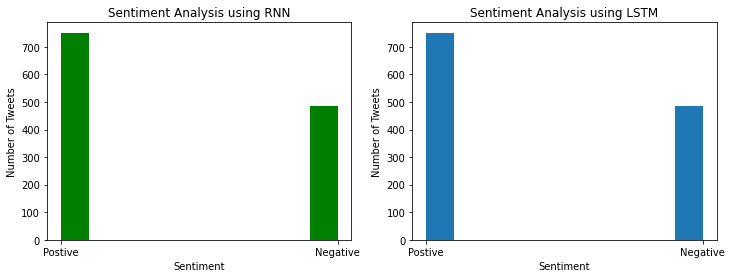

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

# RNN Graph
ax[0].hist(['Postive' if i>0 else 'Negative' for i in df['Predictions_RNN']], color='green')
ax[0].set_xlabel('Sentiment')
ax[0].set_ylabel('Number of Tweets')
ax[0].set_title('Sentiment Analysis using RNN')

# LSTM Graph
ax[1].hist(['Postive' if i>0 else 'Negative' for i in df['Predictions_LSTM']])
ax[1].set_xlabel('Sentiment')
ax[1].set_ylabel('Number of Tweets')
ax[1].set_title('Sentiment Analysis using LSTM')

plt.show()



In [26]:
# Example of 5 positive and 5 negatives

print('Positive sentiment:\n')
for text in df[df['Predictions_LSTM'] > 0].sample(5)['clean_text']:
  print(f'{text}')

print('\n----------------\n')

print('Negative sentiment:\n')
for text in df[df['Predictions_LSTM'] < 0].sample(5)['clean_text']:
  print(f'{text}')


Positive sentiment:

Seattle Mayor says, about the anarchists takeover of her city, “it is a Summer of Love”. These Liberal Dems don’t have a clue. The terrorists burn and pillage our cities, and they think it is just wonderful, even the death. Must end this Seattle takeover now!
The great has a very important new book coming out shortly. “The Trump Century, How Our President Changed the Course Of History Forever”, looks like it will be a big bestseller. Make it Number 1 for Lou. Pre-Order now at A great honor, Lou!
Great Ratings and Reviews Last Night. Thank you!
They spied on the Trump Campaign, and got caught!!!
The Economy is coming back fast!

----------------

Negative sentiment:

My Administration will do everything in its power to prevent weak mayors and lawless cities from taking Federal dollars while they let anarchists harm people, burn buildings, and ruin lives and businesses. We’re putting them on notice today.
THANK YOU! #MAGA
So many people hurt!
“We know what took place